### Домашнее задание №1. Извлечение признаков изображения, поиск по картинкам
Распознавание рукописного ввода на примере базы MNIST

Построить классификатор изображений рукописного ввода на базе MNIST. В качестве шаблона в данной работе можно использовать ipython-ноутбук 002-digit.ipynb.

Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.

В качестве модели классификатора можно использовать любую известную Вам модель, за исключением сверточных нейронных сетей.

Критерием качества классификатора является метрика accuracy. Для получения зачета по данной работе, значение метрики accuracy должно быть больше 0.6. Метрика оценивается на тестовой выборке в рамках контеста Digit Recognizer на Kaggle.

Решение необходимо предоставить в виде ipython-ноутбука с реализацией процесса построения модели и скриншота с финальным результатом на Kaggle.

## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [75]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
p=print

## Загружаем исходные данные

In [11]:
!ls

HW_1.ipynb test.csv   train.csv


In [12]:
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)

In [13]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [14]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

In [15]:
%config InlineBackend.figure_format = 'retina'

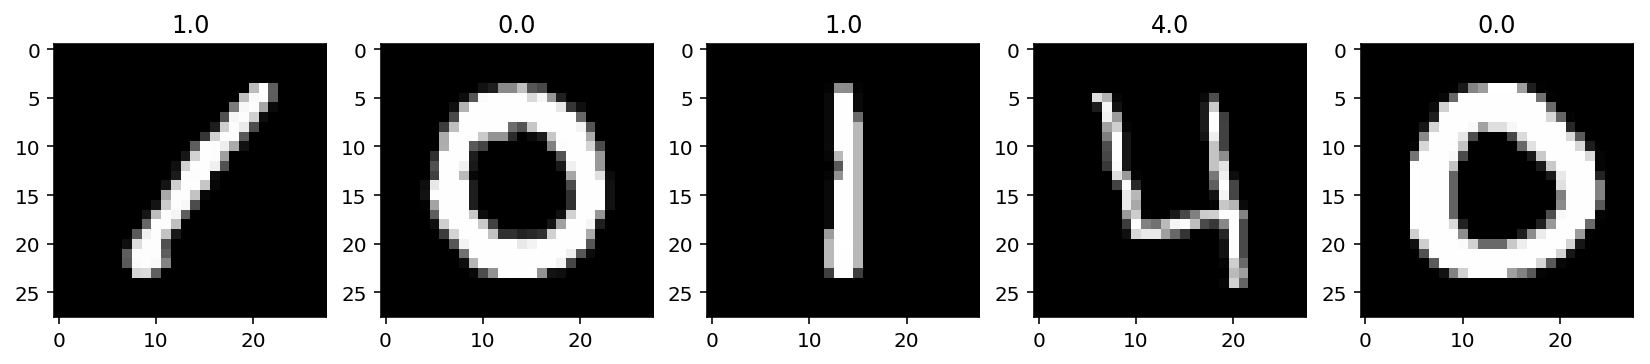

In [16]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [17]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [18]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [19]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [55]:
train_g.shape,train_theta.shape

((42000, 28, 28), (42000, 28, 28))

In [20]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

In [21]:
test_g.shape, test_theta.shape

((28000, 28, 28), (28000, 28, 28))

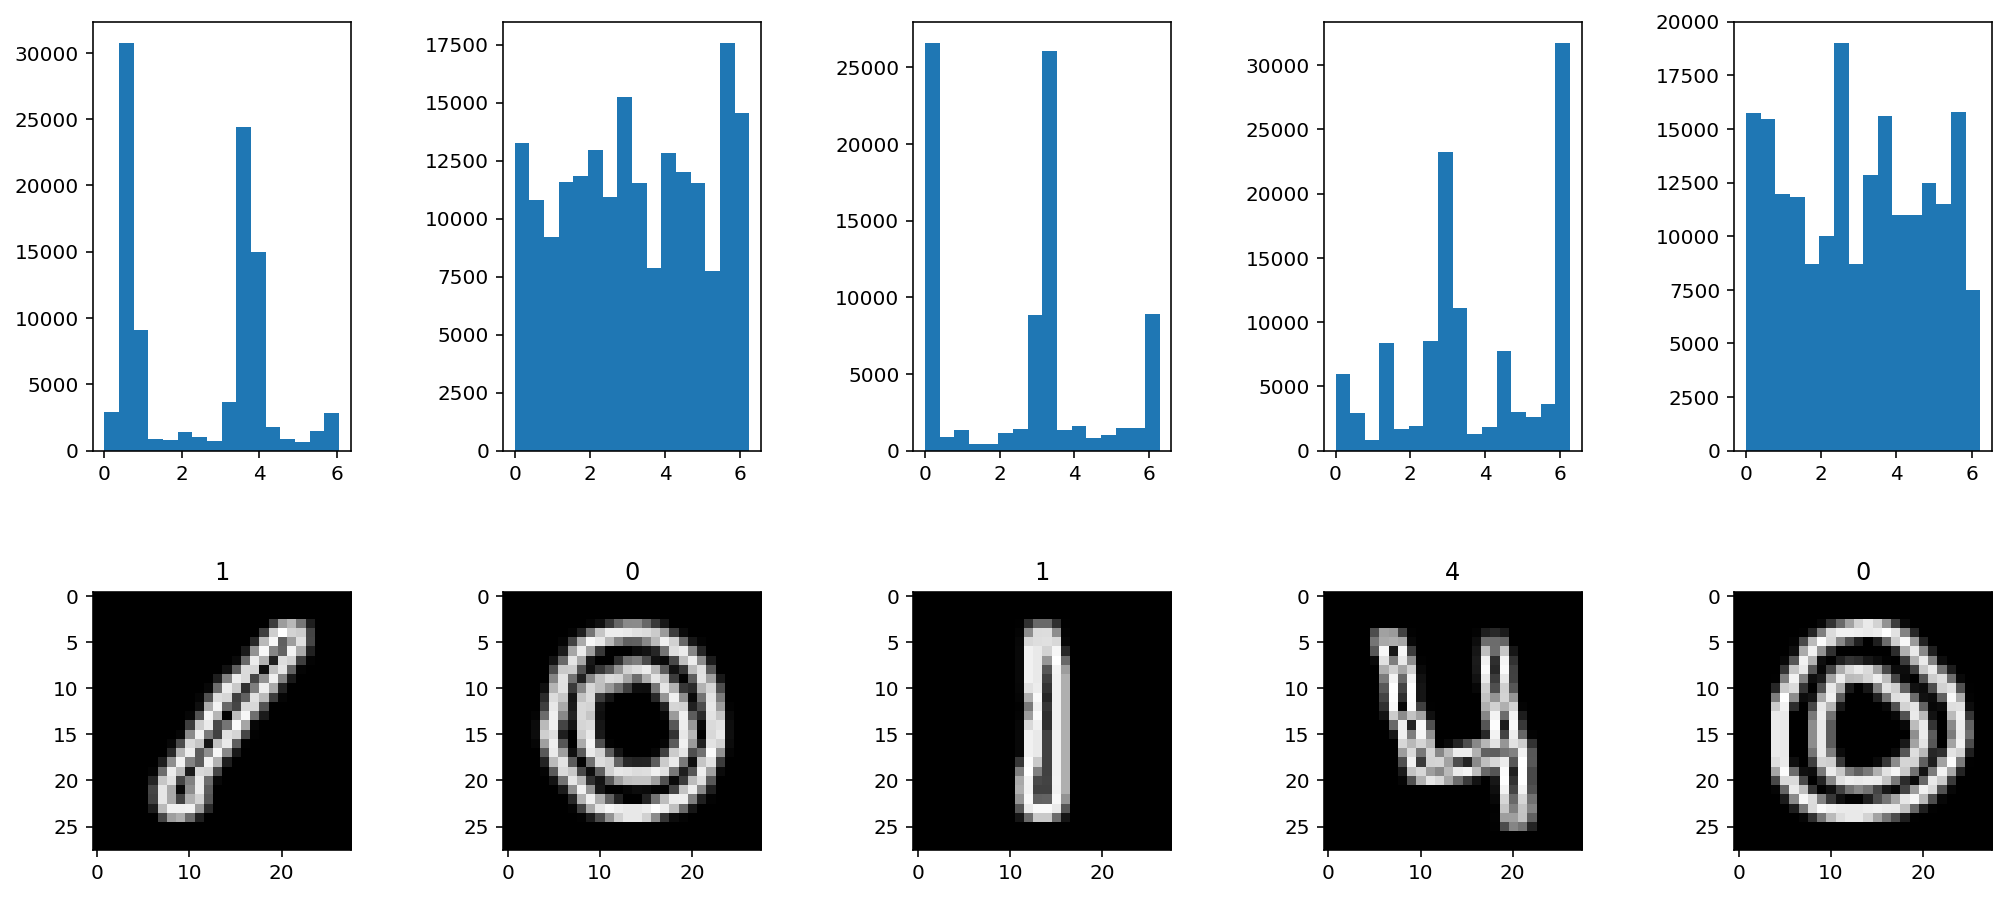

In [23]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%d' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())
    plt.tight_layout()

## Вычисляем гистограммы градиентов

In [28]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [29]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [30]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [31]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [32]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

## Применим PCA()

In [33]:
from sklearn.decomposition import PCA

In [34]:
model_pca = PCA()

In [35]:
model_pca.fit_transform(x_train)

array([[ 2.07029719e-01,  1.64243868e-01,  1.41217113e-01, ...,
        -2.97960682e-02,  6.51448056e-03,  3.76877397e-03],
       [-3.58128931e-01, -3.42767373e-01,  7.54330315e-02, ...,
        -6.75171704e-03,  7.56086963e-03,  3.54671996e-03],
       [-4.28170638e-01, -2.69237227e-01, -8.59534028e-02, ...,
         4.54436566e-02,  1.42640918e-02,  5.69804988e-03],
       ...,
       [-4.44389015e-01, -2.31398084e-01, -1.37363894e-01, ...,
         2.21397370e-02,  6.86572901e-03,  1.05954378e-02],
       [-2.78062845e-01, -6.08437160e-02,  4.87738782e-03, ...,
         7.52415202e-03,  2.62529442e-03,  2.07180116e-02],
       [-1.98348756e-01, -1.76343710e-01, -1.04075264e-01, ...,
        -1.45831111e-02,  9.79597237e-03,  3.29761565e-04]])

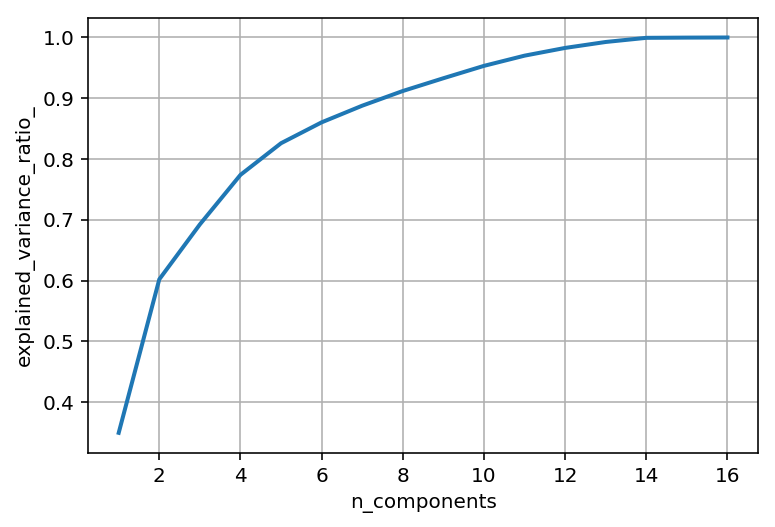

In [51]:
cum_evr = np.cumsum(model_pca.explained_variance_ratio_)
x = np.arange(1,cum_evr.shape[0]+1)
plt.plot(x, cum_evr, linewidth=2)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_');

Обучим модель на 14 компонентах


In [53]:
model_pca = PCA(n_components=14)

In [54]:
model_pca.fit(x_train)

PCA(copy=True, iterated_power='auto', n_components=14, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [56]:
X_pca = model_pca.transform(x_train)
X_test_pca = model_pca.transform(x_val)

## Построение модели logreg

In [61]:
from sklearn.linear_model import LogisticRegression

In [62]:
x = X_pca.copy()
y = y_train.copy()

In [70]:
import warnings
warnings.simplefilter('ignore')

In [71]:
log_reg = LogisticRegression()
log_reg.fit(x,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [72]:
y_val_pred = log_reg.predict(X_test_pca)

In [73]:
from sklearn.metrics import accuracy_score

In [78]:
p(f'Logistic regression score is ',round(accuracy_score(y_val,y_val_pred),4))

Logistic regression score is  0.5574


In [80]:
from sklearn.metrics import classification_report
p(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

         0.0       0.37      0.24      0.29       816
         1.0       0.85      0.97      0.91       909
         2.0       0.41      0.24      0.30       846
         3.0       0.58      0.69      0.63       937
         4.0       0.58      0.49      0.53       839
         5.0       0.52      0.63      0.57       702
         6.0       0.40      0.43      0.41       785
         7.0       0.70      0.76      0.73       893
         8.0       0.44      0.54      0.48       835
         9.0       0.53      0.52      0.52       838

   micro avg       0.56      0.56      0.56      8400
   macro avg       0.54      0.55      0.54      8400
weighted avg       0.54      0.56      0.54      8400



единицу и семерку улавливаем хорошо

## Построение модели randomForest

In [84]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [85]:
random_f = RandomForestClassifier()

In [87]:
params = {'max_depth': np.arange(1, 7)}
grid_search = GridSearchCV(random_f,param_grid=params,n_jobs=-1)
grid_search.fit(x,y)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': array([1, 2, 3, 4, 5, 6])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [88]:
grid_search.best_params_

{'max_depth': 6}

In [89]:
random_f = RandomForestClassifier(max_depth=6)

In [90]:
random_f.fit(x,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [91]:
y_val_pred = random_f.predict(X_test_pca)

In [92]:
p(f'RandomForest score is ',round(accuracy_score(y_val,y_val_pred),4))

RandomForest score is  0.5218


In [93]:
p(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

         0.0       0.36      0.25      0.30       816
         1.0       0.79      0.91      0.85       909
         2.0       0.43      0.20      0.27       846
         3.0       0.56      0.61      0.58       937
         4.0       0.55      0.39      0.46       839
         5.0       0.50      0.60      0.54       702
         6.0       0.35      0.41      0.38       785
         7.0       0.67      0.69      0.68       893
         8.0       0.40      0.57      0.47       835
         9.0       0.49      0.53      0.51       838

   micro avg       0.52      0.52      0.52      8400
   macro avg       0.51      0.52      0.50      8400
weighted avg       0.52      0.52      0.51      8400



Только единицу угадываем хорошо

## Построение модели SVM

In [98]:
from sklearn.svm import SVC

In [99]:
svm = SVC(kernel='rbf',random_state = 0, gamma = 90.0, C=100.0)
svm.fit(x,y)

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=90.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [101]:
y_val_pred = svm.predict(X_test_pca)

In [102]:
p(f'SVM is ',round(accuracy_score(y_val,y_val_pred),4))

SVM is  0.5601


## Построение модели KNeighborsClassifier

In [103]:
from sklearn.neighbors import KNeighborsClassifier

In [105]:
params = {'n_neighbors':np.arange(1, 10)}

grid_search = GridSearchCV(KNeighborsClassifier(), params, n_jobs=-1)
grid_search.fit(x, y)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [106]:
grid_search.best_params_

{'n_neighbors': 9}

In [108]:
kn_neigh = KNeighborsClassifier(n_neighbors=9,n_jobs=-1)
kn_neigh.fit(x,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
           weights='uniform')

In [109]:
y_val_pred = kn_neigh.predict(X_test_pca)

In [110]:
p(f'KNeighborsClassifier is ',round(accuracy_score(y_val,y_val_pred),4))

KNeighborsClassifier is  0.6008


In [111]:
p(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

         0.0       0.33      0.48      0.39       816
         1.0       0.94      0.95      0.95       909
         2.0       0.43      0.37      0.40       846
         3.0       0.61      0.67      0.64       937
         4.0       0.67      0.67      0.67       839
         5.0       0.62      0.59      0.60       702
         6.0       0.42      0.38      0.40       785
         7.0       0.86      0.72      0.78       893
         8.0       0.51      0.46      0.48       835
         9.0       0.67      0.64      0.65       838

   micro avg       0.60      0.60      0.60      8400
   macro avg       0.61      0.59      0.60      8400
weighted avg       0.61      0.60      0.60      8400



In [112]:
from sklearn.metrics import confusion_matrix
p(confusion_matrix(y_val,y_val_pred))

[[393   7  53  35  24  17 128   1 125  33]
 [  9 866   1   0  15   0   2   4   2  10]
 [121   0 317 143  11 117  46  13  63  15]
 [ 47   0 104 631   3  64  10   2  72   4]
 [ 45  28   6   3 564   1  79  29   8  76]
 [ 24   0  82 127   0 417   8   6  33   5]
 [224   4  52  14  82   8 297  11  46  47]
 [ 21   9  38   4  79  16  27 639   6  54]
 [229   0  48  62   6  31  41   5 387  26]
 [ 70   3  34  13  53   6  68  34  21 536]]


KNeighborsClassifier дал лучший результат, попробуем его засабмитить

In [ ]:
# dealing with test df

In [119]:
model_pca_test = PCA(n_components=14)

In [120]:
model_pca_test.fit(test_hist)

PCA(copy=True, iterated_power='auto', n_components=14, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [121]:
test_hist = model_pca.transform(test_hist)

In [123]:
pred_test = kn_neigh.predict(test_hist).astype(int)

## Готовим файл для отправки

In [124]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%d\n' % (i, p))

In [125]:
!head submit.txt

ImageId,Label
1,3
2,3
3,9
4,0
5,3
6,7
7,0
8,3
9,3


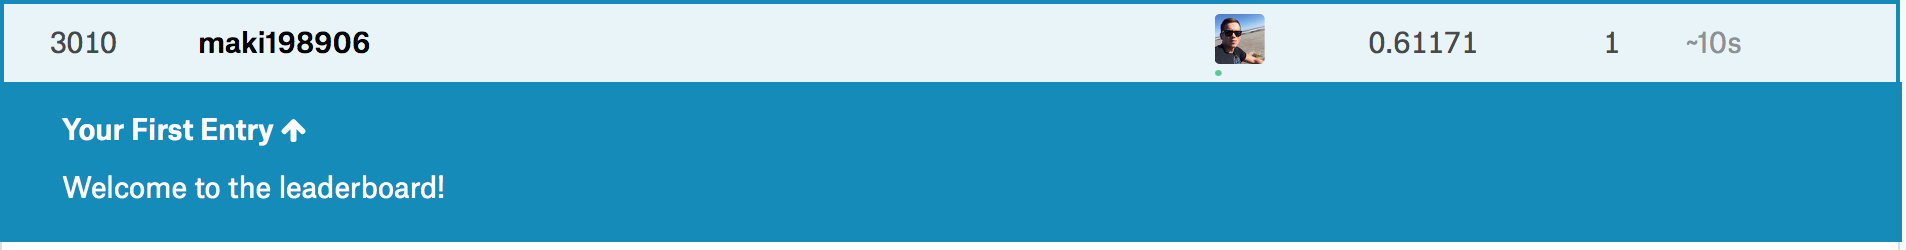

In [126]:
from IPython.display import Image
Image("kaggle.png")